# Implatation Depth calculations of Fl-289 SRIM vs Geant4


In [1]:
%run GenerateStoppingPower.ipynb

/home/yulia/anaconda3/lib/python3.7/site-packages/srim/core/elementdb.py:10: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  return yaml.load(open(dbpath, "r"))


SRIM stopping power successfully calculated
	Calculate energy loss as a function of traversed target material with function 'GetElossAfterX(E_init, x)'
	Calculate traversed target material as a function of energy loss 'GetXAfterEloss(E_init, E_after)'
	Calculate range in material as a function of energy 'GetRange(E_init)'
	Units: MeV, µm
Successfully imported 'GenerateStoppingPower'
	Class to Generate SRIM Stopping Power and calculate energy loss and traversed material.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.linalg
from matplotlib import colors
import matplotlib as mpl
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd

color_list = plt.rcParams['axes.prop_cycle'].by_key()['color'];
#Customising style
#mpl.rc('lines', linewidth=2, color='r')
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['font.size'] = 24
#mpl.rcParams['savefig.format'] = "eps"
#mpl.rcParams['savefig.dpi'] = 100
#mpl.rcParams['text.usetex'] = True
#mpl.rcParams['figure.figsize'] = (16,9)

## Material

In [3]:
# Construct a layer of SiO2, arbitrary width (as it is not relevant for these calcs)
layer = Layer({
    'Si': {
        'stoich': 1,
        #'E_d': 35.0, # Displacement Energy
        #'lattice': 0.0,
        #'surface': 3.0
    },
    'O': {
        'stoich': 2,
        #'E_d': 20.0, # Displacement Energy
        #'lattice': 0.0,
        #'surface': 3.0
    }
}, density=2.32, width=10000.0)

# Fl-289

## SRIM calculations

In [4]:
# Construct ion
A, E_per_A_max = 289, 7e6 # nucleon number, eV 
energy_max = A*E_per_A_max
#print("Max energy=", energy_max)
ion = Ion('U', energy=energy_max, mass=A)

Fl289 = GenerateStoppingPower(layer, ion, z_ion=114)

Extrapolating stopping power for ion with z= 114
Mean scaling factor: 1.3309325475011262
SRIM stopping power successfully calculated
	Calculate energy loss as a function of traversed target material with function 'GetElossAfterX(E_init, x)'
	Calculate traversed target material as a function of energy loss 'GetXAfterEloss(E_init, E_after)'
	Calculate range in material as a function of energy 'GetRange(E_init)'
	Units: MeV, µm


In [5]:
print("Range =", Fl289.GetRange(22, from_sr=True), "µm")

Range = 3.096210212861479 µm


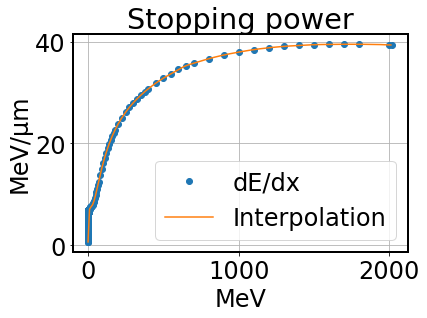

In [6]:
plt.plot(Fl289.energy_raw, Fl289.dEdX_raw, marker='o', label='dE/dx', linestyle='')
plt.plot(Fl289.energy_interp, Fl289.f_dEdX(Fl289.energy_interp), label='Interpolation')
#plt.plot(energy, results.data[2], label='Sn')
plt.legend()

plt.xlabel('MeV')
plt.ylabel('MeV/µm')
plt.title("Stopping power")
#plt.xscale('log')
#plt.yscale('log')
#plt.xlim(1e-2, 1e2)
#plt.ylim(1, None)
plt.grid()
#plt.show()

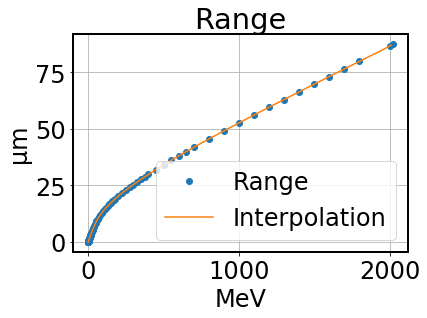

In [7]:
plt.plot(Fl289.energy_raw, Fl289.range_raw, marker='o', label='Range', linestyle='')
plt.plot(Fl289.energy_interp, Fl289.GetRange(Fl289.energy_interp), label='Interpolation')
#plt.plot(energy, results.data[2], label='Sn')
plt.legend()

plt.xlabel('MeV')
plt.ylabel('µm')
plt.title("Range")
#plt.xscale('log')
#plt.yscale('log')
#plt.xlim(1e-2, 1e2)
#plt.ylim(1, None)
plt.grid()
#plt.show()

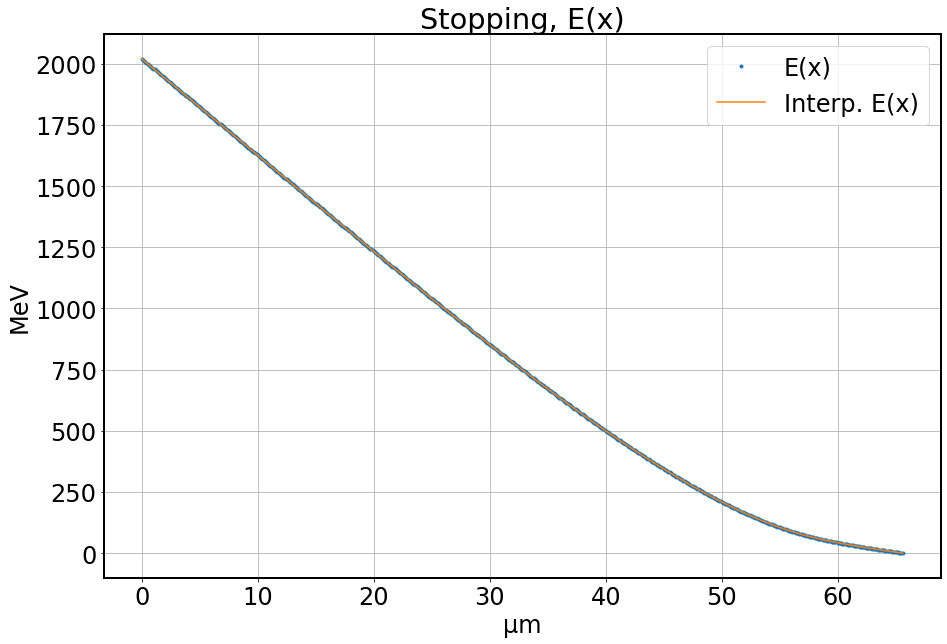

In [8]:
plt.figure(figsize=(15,10))
plt.plot(Fl289.x_loss, Fl289.e_loss, marker='.', label='E(x)', linestyle='')
plt.plot(Fl289.x_loss, Fl289.f_eofx(Fl289.x_loss), marker='', label='Interp. E(x)', linestyle='-')
plt.legend()

plt.xlabel('µm')
plt.ylabel('MeV')
plt.title('Stopping, E(x)')
#plt.xscale('log')
#plt.yscale('log')
#plt.xlim(1e-2, 1e2)
#plt.ylim(1, None)
plt.grid()
#plt.show()